# Metadata analysis

In [31]:
import pandas as pd
import os
import numpy as np
import sklearn.mixture as mixture
import matplotlib as mpl
import matplotlib.pyplot as plt

In [11]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
%matplotlib inline

## Functions

In [12]:
def map_ads(df, title, reference=None, output_file='heatmap'):

    if reference is None:
        reference = df

    # Init numpy array
    #global_max_x = reference['max_x'].max()
    global_max_x = 5000 #manual override!
    global_max_y = 6500 #manual override
    #global_max_y = reference['max_y'].max()
    heatmap = np.zeros([global_max_y, global_max_x], dtype=np.float32)

    # Count the number of advertisements at each pixel
    for i, row in df.iterrows():
        heatmap[int(row['min_y'])-1:int(row['max_y']),
            int(row['min_x'])-1:int(row['max_x'])] += 1

    # Normalize to values between 0 - 1
    heatmap[:,:] /= np.amax(heatmap)
    
    #map[:,:] /= reference.shape[0]

    # Plot and save heatmap image
    plt.imshow(heatmap, cmap='jet')
    #plt.clim(0, 1)
    plt.colorbar()
    plt.title(title)
    plt.savefig(os.path.join(figures_path, title + '_' + output_file + '.png', bbox_inches='tight', dpi=300))
    plt.show()
    plt.clf()

# Preparing Metadata

In [13]:
data_path = '../../../datasets/newspapers_clean/'
figures_path = '../ms/figures/'
processed_data_path = '../data/processed/'

In [14]:
meta_data = pd.read_csv(os.path.join(processed_data_path, 'full_metadata.csv')_
meta_data['date'] = pd.to_datetime(meta_data['date'])

# Analyze metadata

In [15]:
def plot_ad_curve(meta, title, freq):
    meta['date'] = pd.to_datetime(meta['date'])
    meta = meta[meta['newspaper_name'] == title]
    meta['years'] = pd.DatetimeIndex(meta['date']).year
    meta = meta[meta['years'] >= 1945]
    start_year = meta['years'].min()
    end_year = meta['years'].max()
    df = meta.groupby(pd.Grouper(key='date', freq=freq))['page'].count()
    #df = df[df.values != 0] # re
    
    data = df.values
    doublediff = np.diff(np.sign(np.diff(data)))
    peak_locations = np.where(doublediff == -2)[0] + 1

    doublediff2 = np.diff(np.sign(np.diff(-1*data)))
    trough_locations = np.where(doublediff2 == -2)[0] + 1
    
    plt.figure(figsize=(16, 10), dpi=80)
    plt.plot(df.index, df.values, color='tab:red', lw=3)
    plt.scatter(df.index[peak_locations], df.values[peak_locations], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Peaks')
    plt.scatter(df.index[trough_locations], df.values[trough_locations], marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Troughs')

    for t, p in zip(trough_locations, peak_locations):
        plt.text(df.index[p], df.values[p]+1000, int(str(df.index[p])[:4])+1, horizontalalignment='center', color='darkgreen')
        plt.text(df.index[t], df.values[t]-1500, int(str(df.index[t])[:4])+1, horizontalalignment='center', color='darkred')

    plt.yticks(fontsize=12, alpha=.7)

    title = title.capitalize()
    plt.title(f'Yearly number of ads in {title} ({start_year} - {end_year})', fontsize=22)
    plt.grid(axis='both', alpha=.3)

    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.3)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.3)  
    plt.savefig(os.path.join(figures_path, f'{title}_ad_curve.jpg'))
    plt.show()

    

In [18]:
meta_data['years'] = pd.DatetimeIndex(meta_data['date']).year
meta_data = meta_data[meta_data['years'] <= 1990] #filter everything before 1991

### Show totals all newspapers

In [19]:
start = meta_data.groupby(['newspaper_name'])['years'].min()
end = meta_data.groupby(['newspaper_name'])['years'].max()
totals = meta_data.groupby(['newspaper_name'])['page'].count()

corpus_df = pd.concat([start, end, totals], axis=1)
corpus_df.columns = ['start_year', 'end_year', 'total_ads']
corpus_df

start_year  end_year  total_ads
newspaper_name                                               
algemeen_handelsblad                1906      1970     979312
detijd                              1890      1958     550475
het_volk                            1919      1945     191626
nieuwe_rotterdamsche_courant        1909      1929     472536
nn                                  1890      1990    2079109
nrc                                 1970      1990     460996
parool                              1945      1990    1626024
telegraaf                           1893      1990    3777982
trouw                               1946      1990    1154746
vaderland                           1919      1945     317440
vk                                  1940      1990    1193558
vv                                  1945      1990    1584863

In [26]:
selected_papers = ['algemeen_handelsblad', 'detijd', 'het_volk',
                  'nieuwe_rotterdamsche_courant', 'nrc', 'parool',
                  'telegraaf', 'trouw', 'vaderland', 'vk', 'vv']

meta_data = meta_data[meta_data['newspaper_name'].isin(selected_papers)]

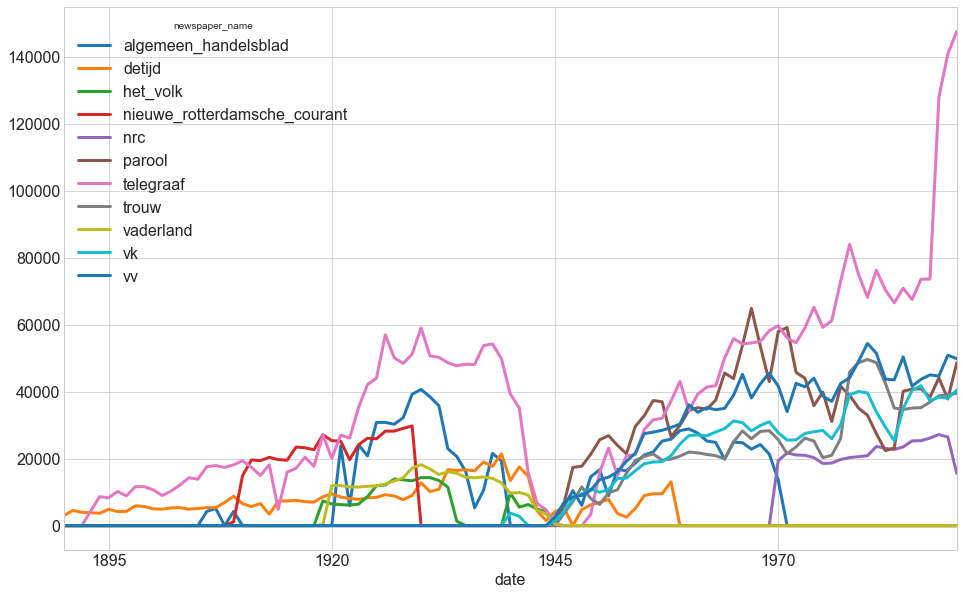

In [27]:
plot = meta_data.groupby(['newspaper_name', 'date'])['page'].count()
plot_df = plot.unstack('newspaper_name').loc[:, ]
plot_df.reset_index().groupby(pd.Grouper(key='date', freq='Y')).sum().plot(figsize=(16,10), lw=3)

In [28]:
trouw_total = meta_data[meta_data['newspaper_name'] == 'trouw'].shape[0]
vk_total = meta_data[meta_data['newspaper_name'] == 'vk'].shape[0]

In [29]:
print(f'Total number of ads in Trouw: {trouw_total}')
print(f'Total number of ads in Volkskrant: {vk_total}')

Total number of ads in Trouw: 1154746
Total number of ads in Volkskrant: 1193558


## plot single newspaper

/Users/melvinwevers/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


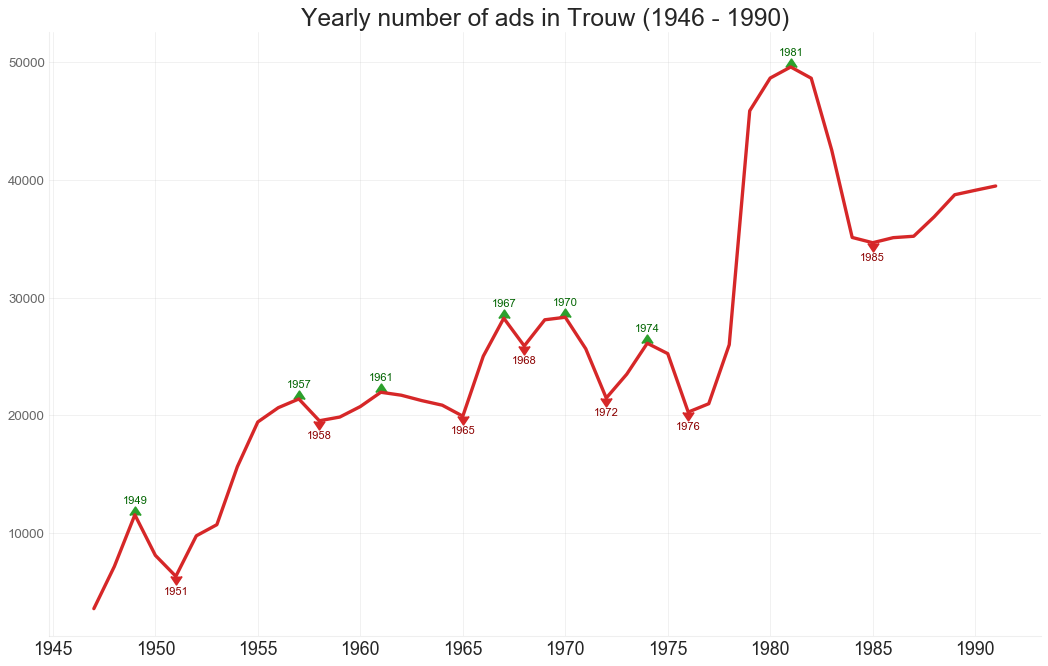

In [32]:
plot_ad_curve(meta_data, 'trouw', 'Y')

### Study Size

In [33]:
meta_data['size'] = meta_data['size'].astype(int)
meta_data['log_size'] = np.log10(meta_data['size'])

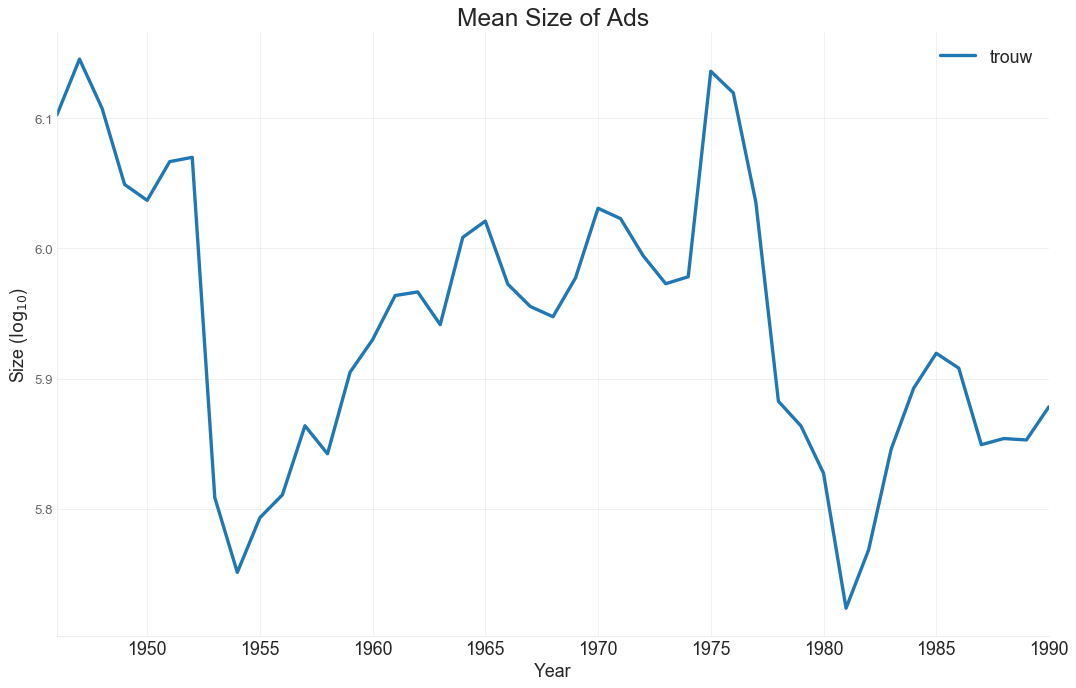

In [34]:
plt.figure(figsize=(16, 10), dpi=80)

meta_data['years'] = pd.DatetimeIndex(meta_data['date']).year
meta_data = meta_data[meta_data['years'] >= 1945]

#meta_data[meta_data['newspaper_name'] == 'vk'].groupby(pd.Grouper(key='date', freq='Y')).mean()['log_size'].plot(label='vk', color='tab:red', lw=3)
meta_data[meta_data['newspaper_name'] == 'trouw'].groupby(pd.Grouper(key='date', freq='Y'))['log_size'].mean().plot(label='trouw', color='tab:blue', lw=3)
plt.legend()


plt.yticks(fontsize=12, alpha=.7)

#plt.ylim(0, 6.5)
plt.title('Mean Size of Ads', fontsize=22)
plt.grid(axis='both', alpha=.3)
plt.ylabel(r'Size ($\log_{10}$)')
plt.xlabel(r'Year')
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)  
plt.savefig(os.path.join(figures_path, 'mean_size.jpg'))
plt.show()

### Make heatmap

In [37]:
trouw_meta = meta_data[meta_data['newspaper_name'] == 'trouw'].sample(10000)

In [38]:
max_pages = trouw_meta.groupby(pd.Grouper(key='date', freq='D'))['page'].max()

In [39]:
#calculate relative page position

trouw_meta = pd.merge(trouw_meta, max_pages, on='date')
trouw_meta.rename(columns={'page_x': 'page', 'page_y': 'total_pages'}, inplace=True)
trouw_meta['rel_page'] = trouw_meta['page'] / trouw_meta['total_pages']

In [ ]:
trouw_meta['normalized_perc_digits'] = (trouw_meta['perc_digits']-trouw_meta['perc_digits'].mean())/trouw_meta['perc_digits'].std()
trouw_meta['normalized_character_proportion'] = (trouw_meta['character_proportion']-trouw_meta['character_proportion'].mean())/trouw_meta['character_proportion'].std()
trouw_meta['normalized_page'] = (trouw_meta['rel_page']-trouw_meta['rel_page'].mean())/trouw_meta['rel_page'].std()

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(10, 6)) 

trouw_meta['normalized_page'].plot(kind='density', title=r'Normalized Page Number', ax=axes[0])
trouw_meta['rel_page'].plot(kind='density', title=r'Normalized Page Number', ax=axes[1])
trouw_meta['w_log10'].plot(kind='density', title=r'Width ($\log_{10}$)', ax=axes[2])
trouw_meta['h_log10'].plot(kind='density', title=r'Height ($\log_{10}$)', ax=axes[3])
# #xlim = (1.2, 3.8)
# axes[1].set_xlim(*xlim) 
# axes[2].set_xlim(*xlim) 
plt.tight_layout()

In [325]:
# make the even odd variable
trouw_meta['even_odd'] = np.where(trouw_meta['page'] % 2 == 0, 'even', 'odd')

Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True


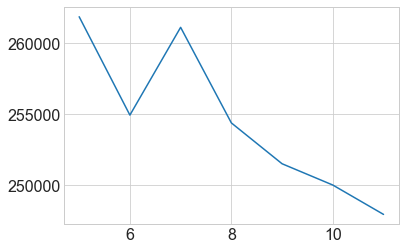

In [42]:
#figure out optimal number of components
data = trouw_meta[['w', 'h', 'rel_page']]

n_components = np.arange(5, 12)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0, verbose=1, max_iter=1500).fit(data)
          for n in n_components]

plt.plot(n_components, [m.aic(data) for m in models], label='AIC')

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
Initialization converged: True


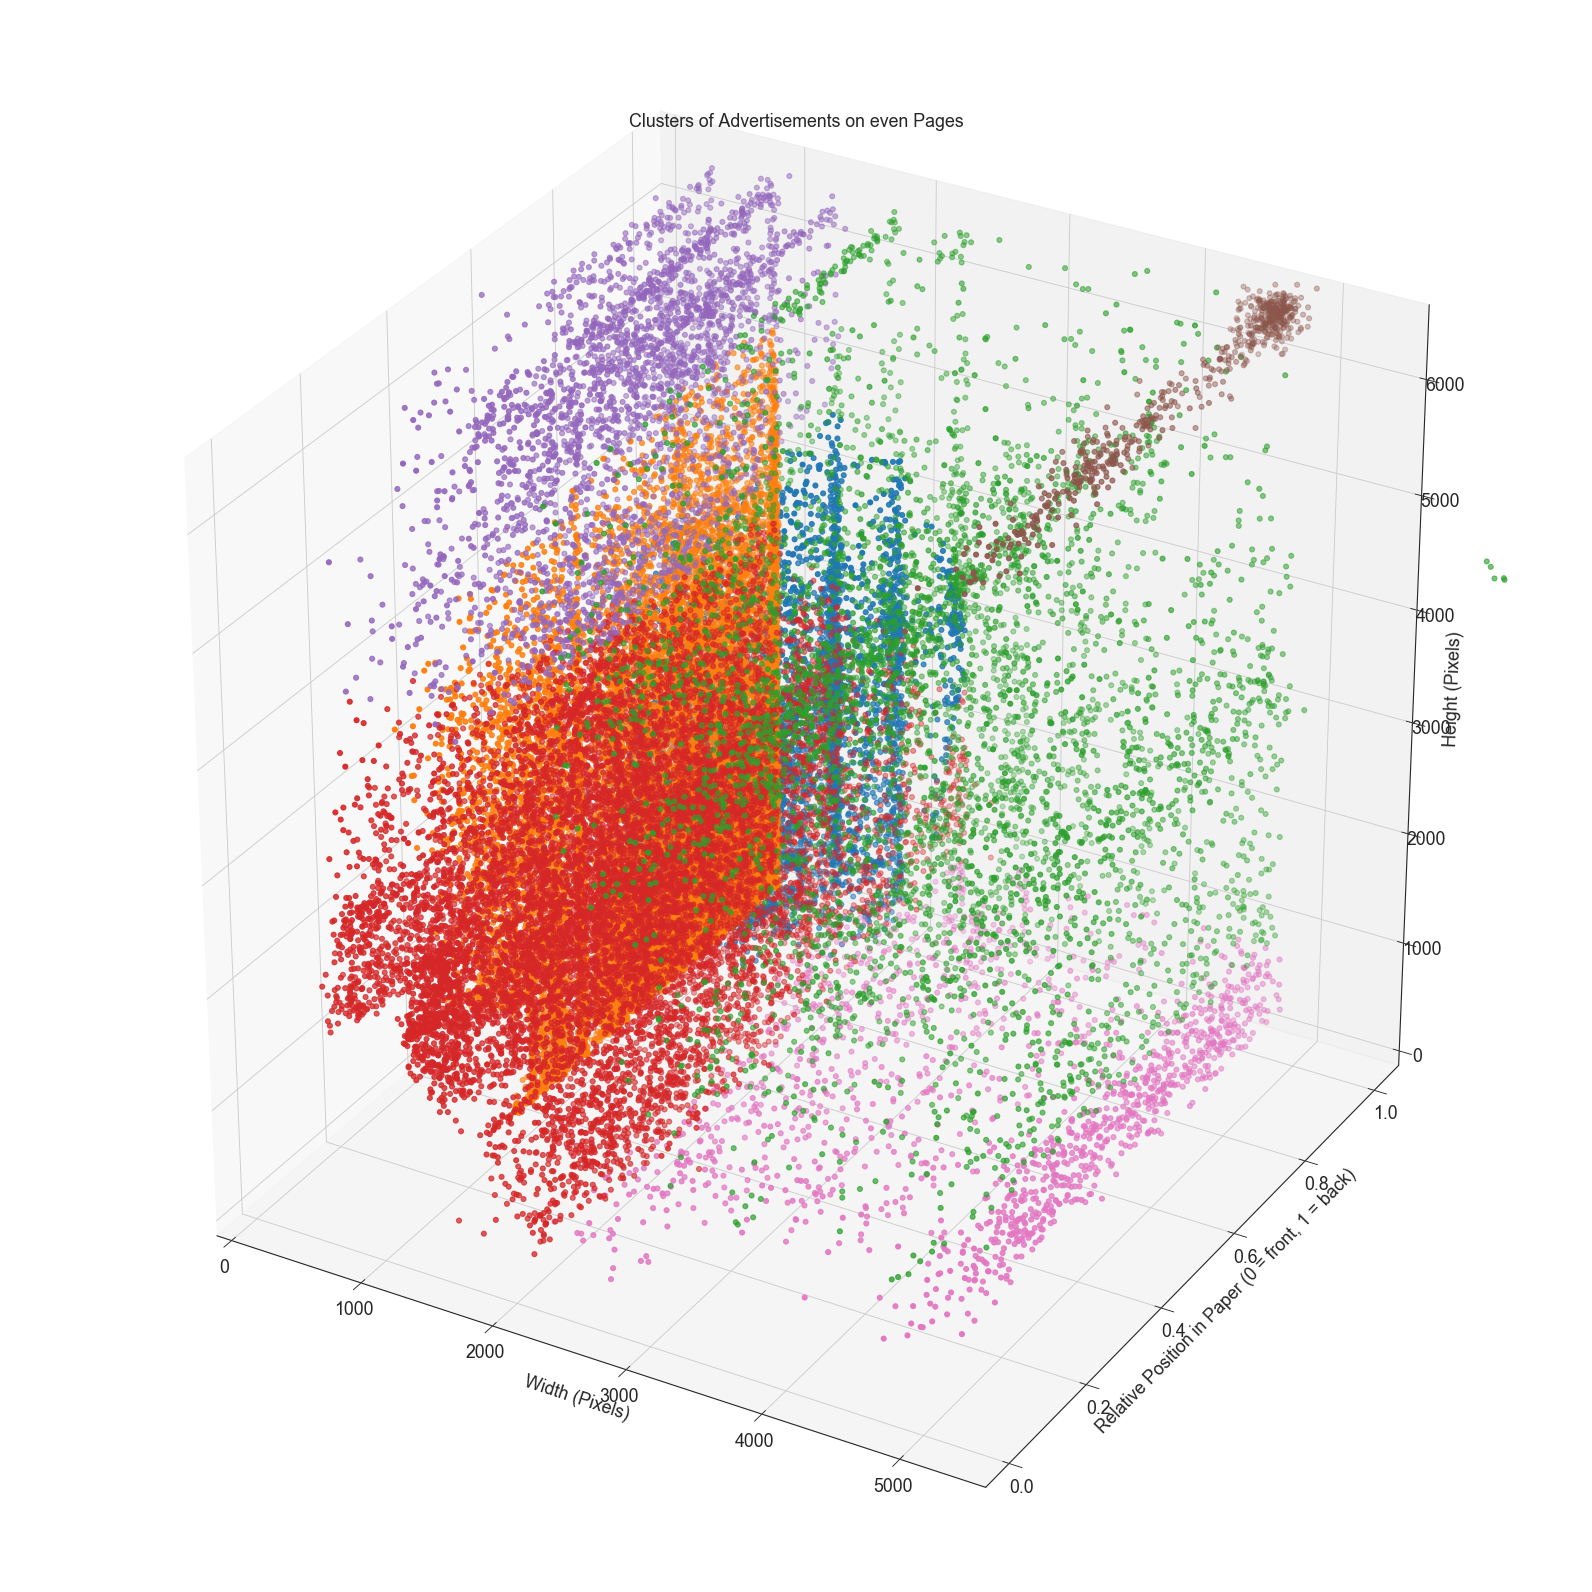

In [519]:
data = trouw_meta[['w', 'h', 'rel_page']]
gmm = mixture.GaussianMixture(n_components=9, covariance_type='full', verbose=1, max_iter=1500).fit(data)


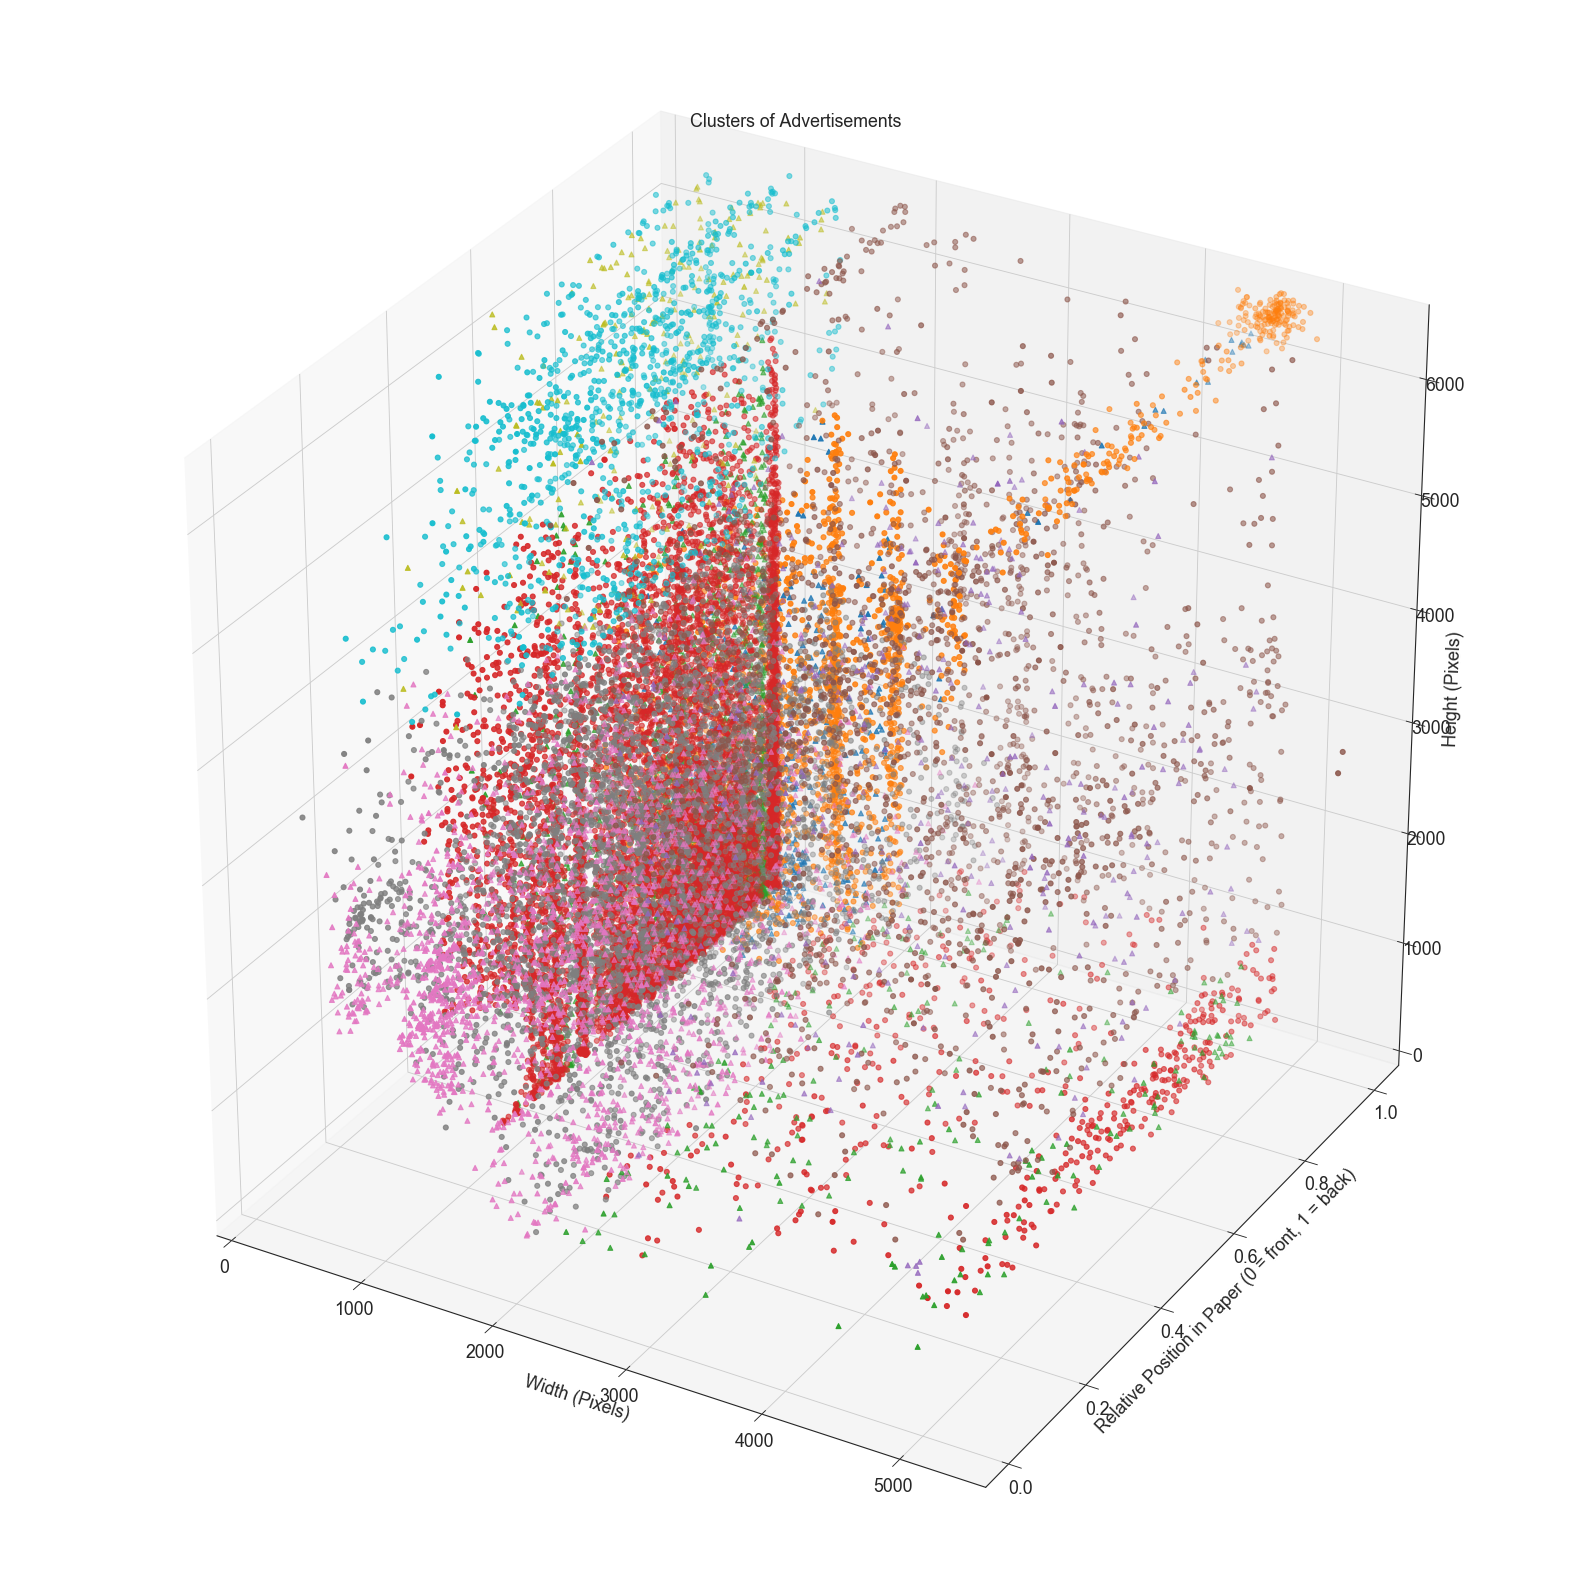

In [547]:
trouw_subset = trouw_meta.sample(50000)
trouw_subset['classes'] = trouw_subset.apply(lambda x: gmm.predict([[x['w'], x['h'], x['rel_page']]])[0], axis=1)
plot_sizes(trouw_subset)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
GMM parameters for odd
μ's = [[5.49840e+02 8.02550e+02 5.50000e-01]
 [8.04260e+02 1.97008e+03 9.00000e-01]
 [1.10484e+03 7.79910e+02 4.20000e-01]
 [1.28490e+03 1.84434e+03 4.00000e-01]
 [2.10579e+03 2.87249e+03 5.70000e-01]
 [2.77794e+03 5.49100e+02 5.50000e-01]
 [1.86241e+03 6.26984e+03 7.50000e-01]]
Σ's = [[[ 7.34247950e+03  8.30046800e+02 -1.82750000e+01]
  [ 8.30046800e+02  2.09430783e+05 -1.85411000e+01]
  [-1.82750000e+01 -1.85411000e+01  1.05700000e-01]]

 [[ 8.02366490e+04 -9.91181558e+04 -2.01000000e-02]
  [-9.91181558e+04  1.79049001e+06 -1.63485000e+01]
  [-2.01000000e-02 -1.63485000e+01  4.70000000e-03]]

 [[ 2.20421339e+04  1.90058233e+04 -3.18261000e+01]
  [ 1.90058233e+04  1.97634456e+05 -7.45148000e+01]
  [-3.18261000e+01 -7.45148000e+01  1.03700000e-01]]

 [[ 2.03545581e+05 -1.81400254e+05 -2.21248000e+01]
  [-1.81400254e+05  6.64539551e+05 -6.74980000e+00]
  [-2

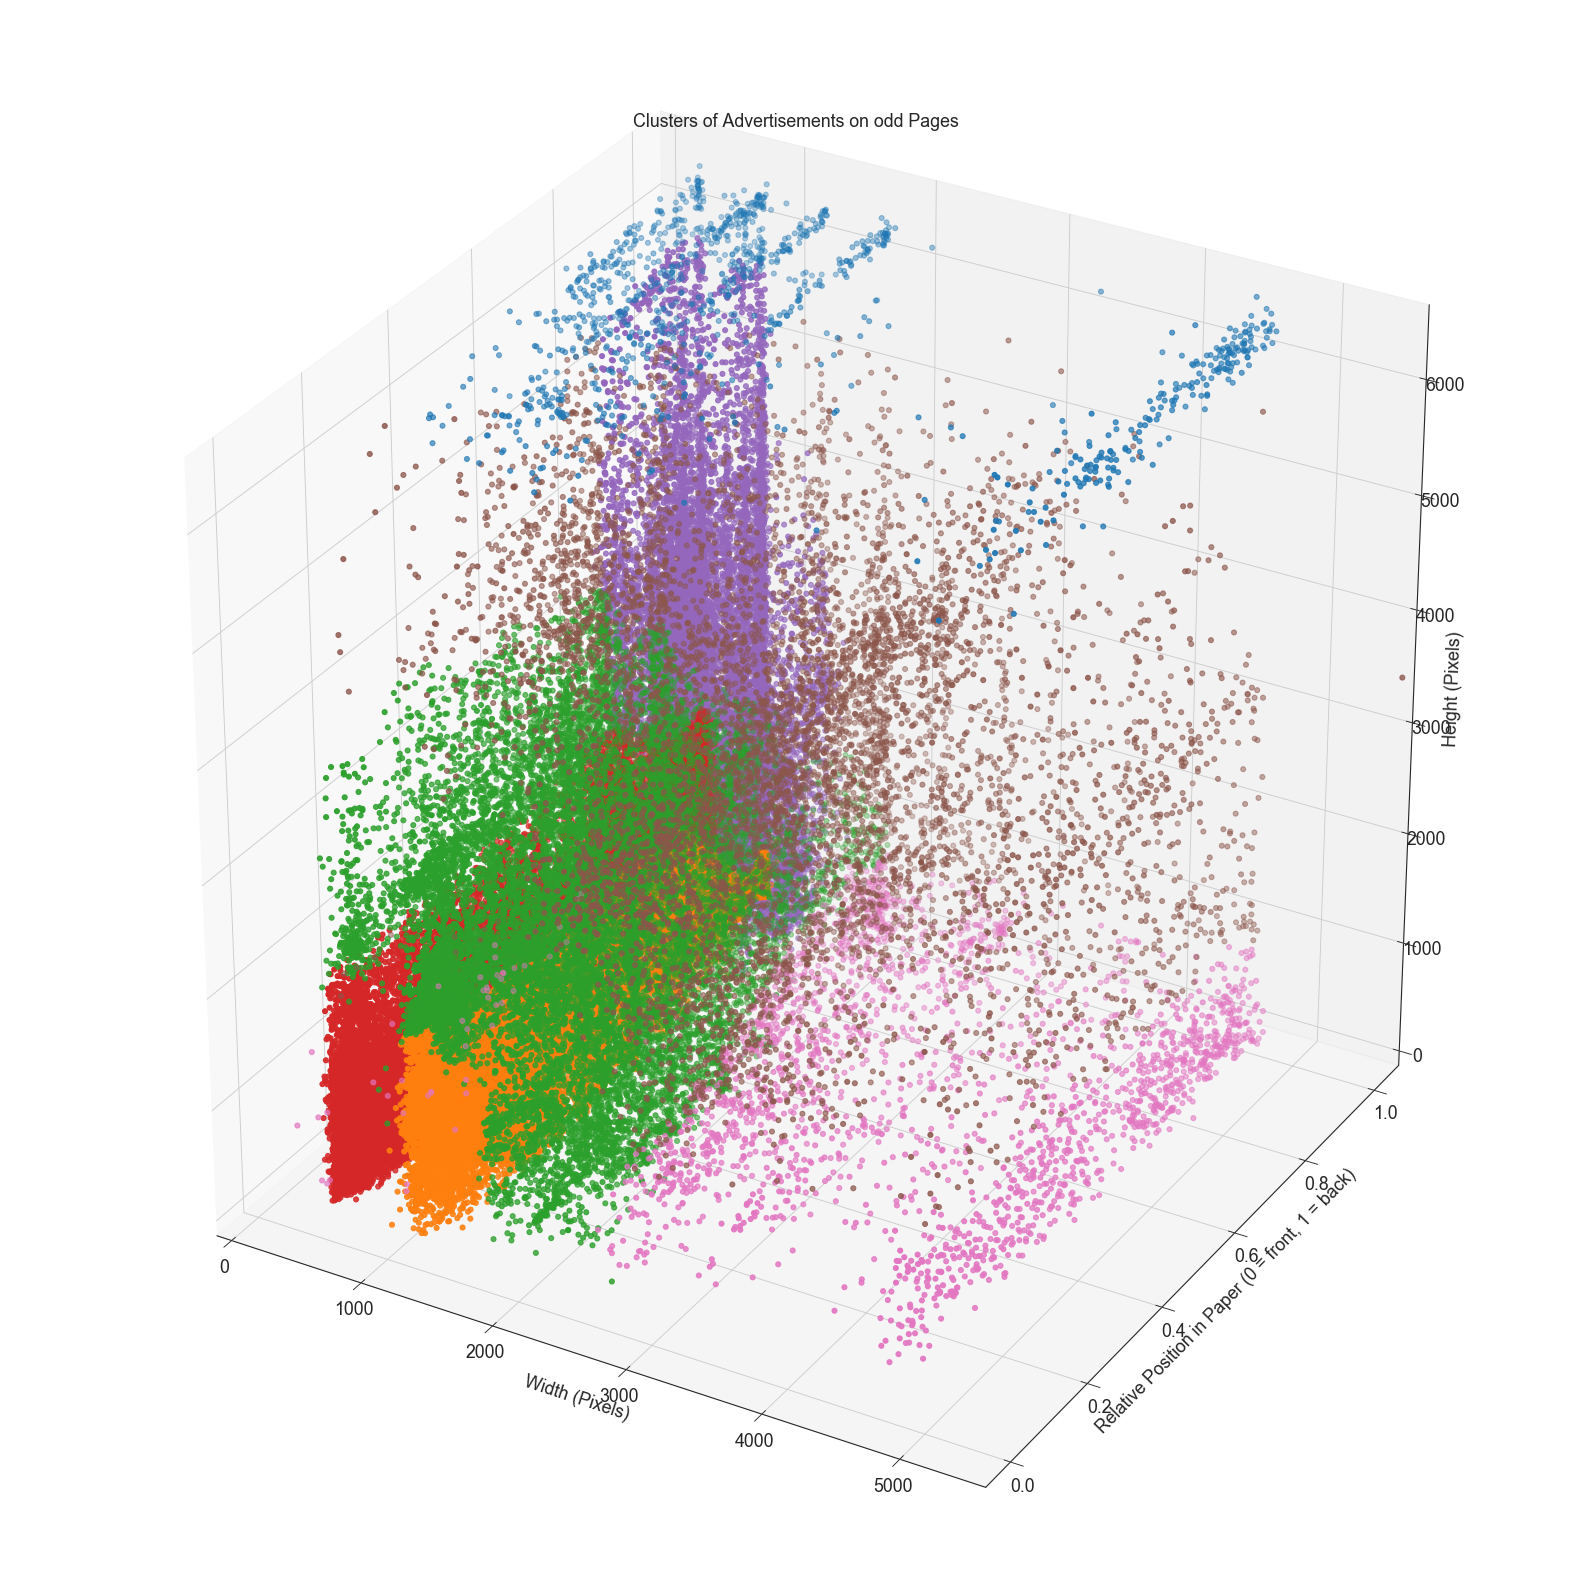

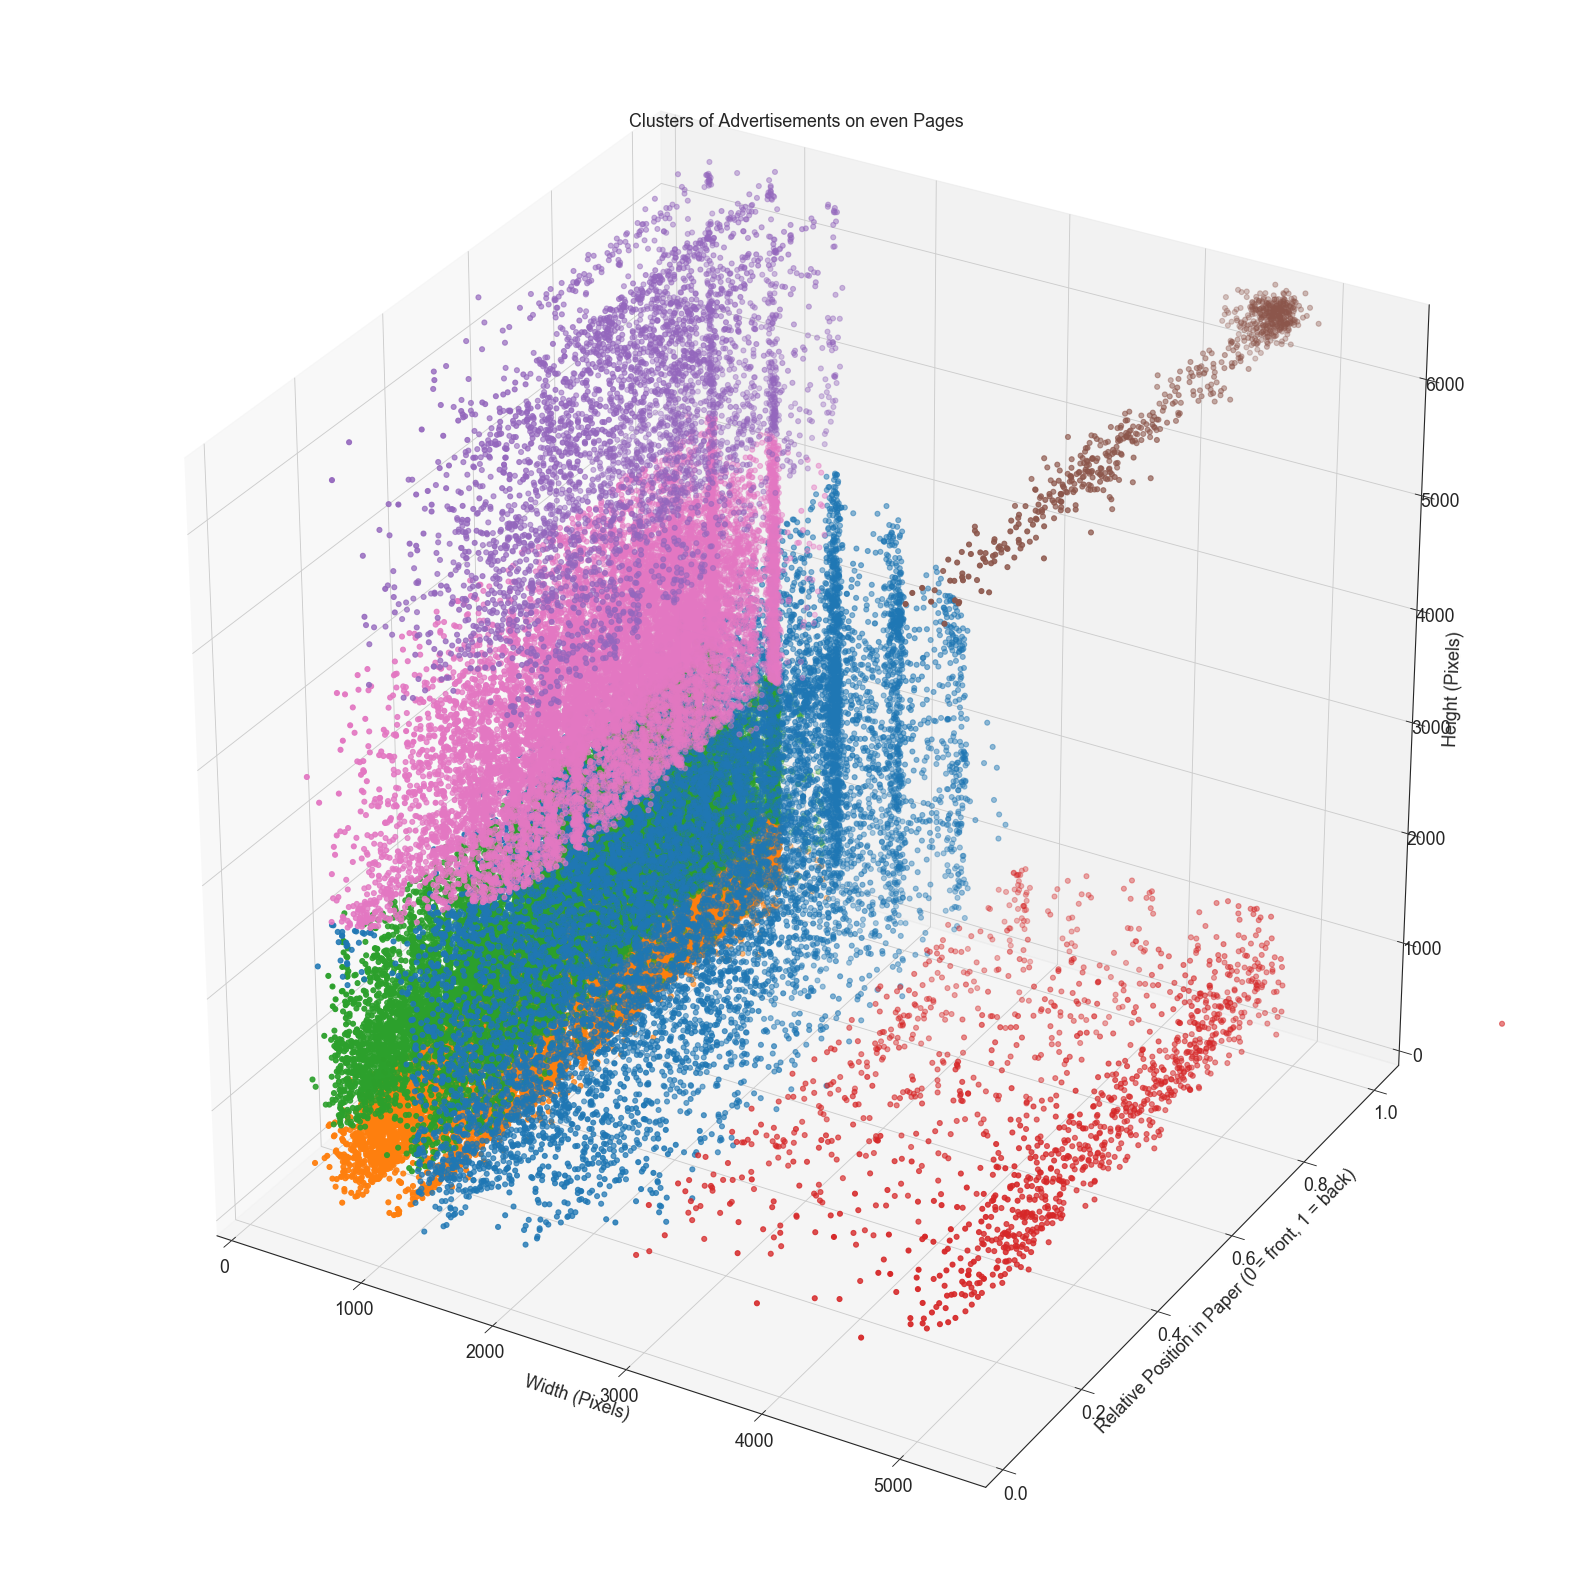

In [517]:
for side in ['odd', 'even']:
    data = trouw_meta[trouw_meta['even_odd'] == side][['w', 'h', 'rel_page']]
    if side == 'odd':
        gmm = mixture.GaussianMixture(n_components=7, covariance_type='full', verbose=1, max_iter=1500).fit(data)
    else:
        gmm = mixture.GaussianMixture(n_components=8, covariance_type='full', verbose=1, max_iter=1500).fit(data)
        
    order = np.argsort(gmm.weights_)[::-1]
    means, covariances, weights = gmm.means_[order], gmm.covariances_[order], gmm.weights_[order]
    print(f'GMM parameters for {side}')
    print("μ's =", means.round(2))
    print("Σ's =", covariances.round(4))
    print("θ's =", weights.round(2))
    
    trouw_subset = trouw_meta[trouw_meta['even_odd'] == side].sample(100000)
    trouw_subset['classes'] = trouw_subset.apply(lambda x: gmm.predict([[x['w'], x['h'], x['rel_page']]])[0], axis=1)
    plot_sizes(trouw_subset, side)

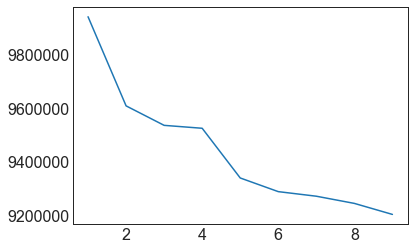

In [508]:
plt.plot(n_components, [m.aic(data) for m in models], label='AIC')

In [487]:




#gmm = mixture.GaussianMixture(n_components=, verbose=1, max_iter=1500) 

# trouw_meta['even_odd'] = np.where(trouw_meta['page'] % 2 == 0, 'even', 'odd')





Initialization 0
  Iteration 10
Initialization converged: True
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True


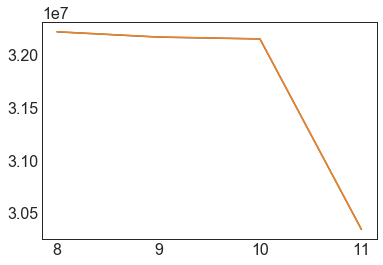

In [488]:
plt.plot(n_components, [m.aic(data) for m in models], label='AIC')


In [535]:
sides = ['odd', 'even']
markers = ['^', 'o']

for marker, side in zip(sides, markers):
    print(marker)

odd
even


In [545]:
def plot_sizes(df):
    
    fig = plt.figure(figsize=(20,20), dpi=80)
    from matplotlib.pyplot import cm
    ax = fig.add_subplot(111, projection='3d')

    colors=cm.rainbow(np.linspace(0,1,7))

    for i, (mean, cov, color) in enumerate(zip(gmm.means_, gmm.covariances_, colors)):
        
        ax.scatter(df[df['classes'] == i]['w'], df[df['classes'] == i]['rel_page'], df[df['classes'] == i]['h'], depthshade=True,cmap='tab10', s=80, facecolors='none)


    ax.view_init(None, None)
    ax.set_xlabel('Width (Pixels)')
    ax.set_ylabel('Relative Position in Paper (0 = front, 1 = back)')
    ax.set_zlabel('Height (Pixels)')

    ax.set_zlim3d(0, 6500)  
    ax.set_xlim3d(0, 5500)  
    # plt.xlabel(r'Width')
    # plt.ylabel(r'Page Number (normalized)')
    # plt.zslabel(r'Height')
    plt.title(f'Clusters of Advertisements')
    plt.tight_layout()
    plt.savefig(f'clusters_sizes.jpg')


SyntaxError: EOL while scanning string literal (<ipython-input-545-5d06ab281b55>, line 11)

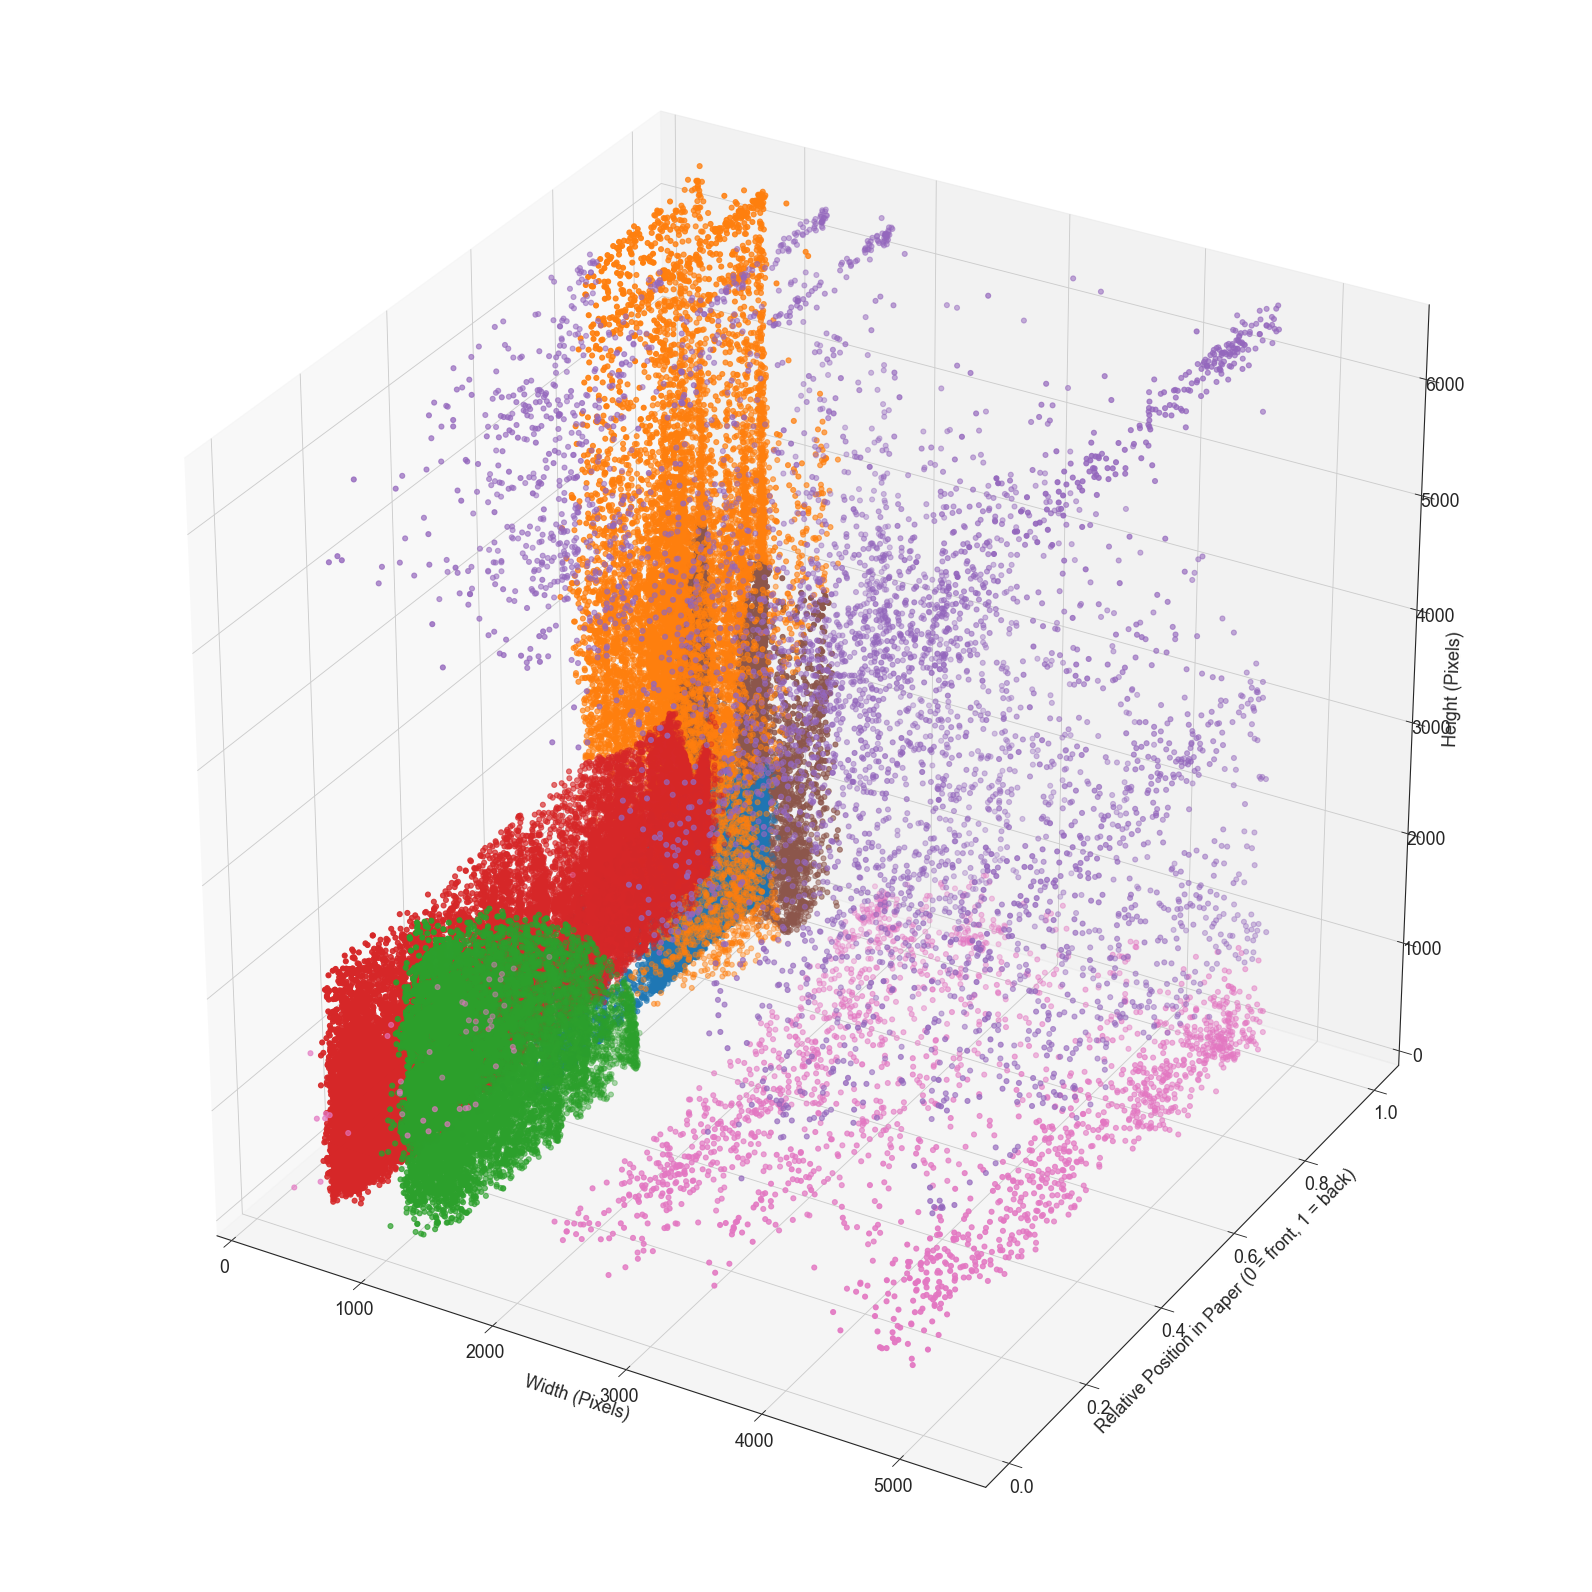

In [512]:
fig = plt.figure(figsize=(20,20), dpi=80)
from matplotlib.pyplot import cm
ax = fig.add_subplot(111, projection='3d')

colors=cm.rainbow(np.linspace(0,1,7))

for i, (mean, cov, color) in enumerate(zip(gmm.means_, gmm.covariances_, colors)):

    ax.scatter(trouw_subset[trouw_subset['classes'] == i]['w'], trouw_subset[trouw_subset['classes'] == i]['rel_page'], trouw_subset[trouw_subset['classes'] == i]['h'], depthshade=True,cmap='tab10')


ax.view_init(None, None)
ax.set_xlabel('Width (Pixels)')

ax.set_zlabel('Height (Pixels)')

ax.set_zlim3d(0, 6500)  
ax.set_xlim3d(0, 5500)  
# plt.xlabel(r'Width')
# plt.ylabel(r'Page Number (normalized)')
# plt.zslabel(r'Height')
plt.tight_layout()
plt.savefig('even_sizes.jpg')


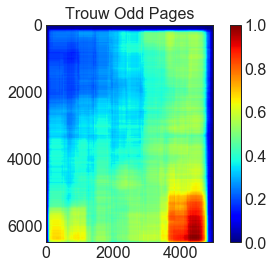

<Figure size 432x288 with 0 Axes>

In [439]:
map_ads(trouw_meta.loc[(trouw_meta['even_odd'] == 'odd')].sample(2000), 'Trouw Odd Pages')


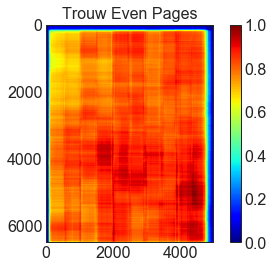

<Figure size 432x288 with 0 Axes>

In [440]:
map_ads(trouw_meta.loc[(trouw_meta['even_odd'] == 'even')].sample(2000), 'Trouw Even Pages')

# classifieds

In [ ]:
meta_data[(meta_data['h'] > 5000) & (meta_data['w'] < 1000)]